In [1]:
import os

import cv2
import numpy as np
import pandas as pd
import fiftyone as fo
from tqdm import tqdm

import torch
from transformers import AutoImageProcessor, AutoModel

from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt

In [2]:
dataset_dir = "../data/opensource-dataset/data/"
annotation_path = "../data/opensource-dataset/labels.json"
dataset_name = "dogs-dataset"

if fo.dataset_exists(dataset_name):
    fo.delete_dataset(dataset_name)

print(f"Creating new dataset: {dataset_name}")
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=dataset_dir,
    labels_path=annotation_path,
    name=dataset_name,
)

Creating new dataset: dogs-dataset
 100% |█████████████| 33995/33995 [21.7s elapsed, 0s remaining, 2.9K samples/s]      


## Проверка на наличие пропусков в данных

In [3]:
base_len = len(dataset)

len(os.listdir(dataset_dir)), base_len

(33995, 33995)

In [4]:
broken_samples = []

for sample in dataset:
    if not sample.detections and 'dogtime' not in sample.filepath and 'dogs_in_depth' not in sample.filepath:
        broken_samples.append(sample)

In [5]:
len(broken_samples)

3

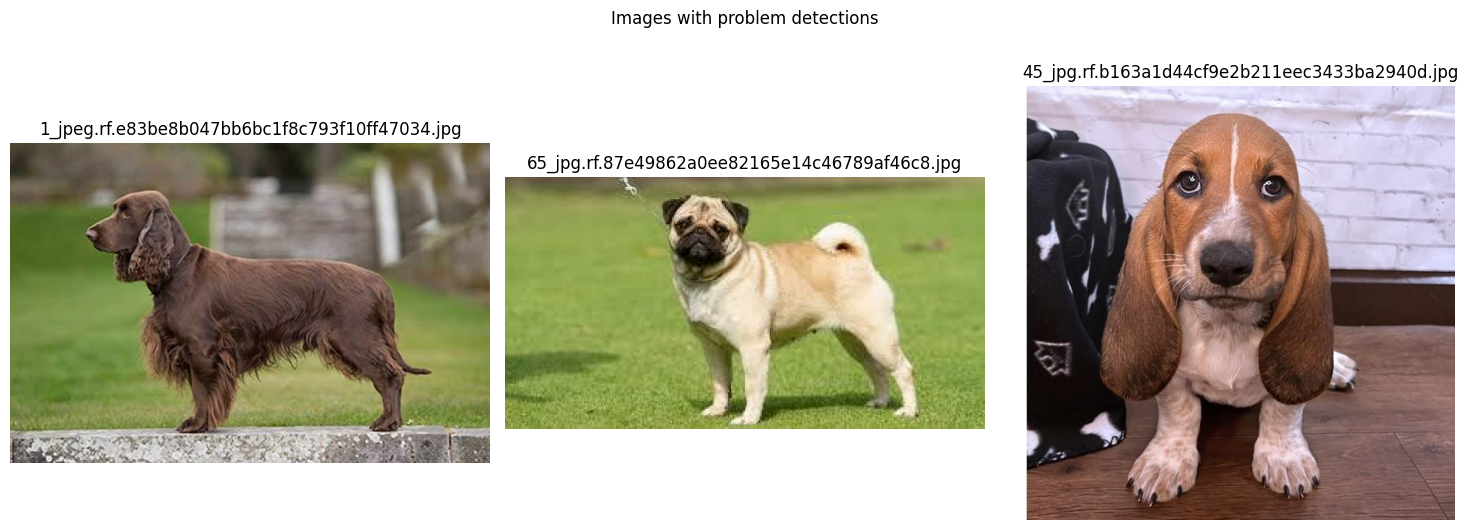

In [6]:
num_images = len(broken_samples)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

if num_images == 1:
    axes = [axes]

for i, (sample, ax) in enumerate(zip(broken_samples, axes)):
    img_path = sample.filepath
    
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax.imshow(img_rgb)
    ax.set_title(os.path.basename(img_path))
    ax.axis('off')

plt.suptitle("Images with problem detections", y=1.05)
plt.tight_layout()
plt.show()

Данные изображения относятся к большим по размеру классам, поэтому проще всего их будет откинуть и не размечать

In [7]:
dataset.delete_samples([item.id for item in broken_samples])
dataset.save()

In [8]:
print('Размер исходного датасета:', base_len)
print('Размер датасета после удаления:', len(dataset))

Размер исходного датасета: 33995
Размер датасета после удаления: 33992


## Уменьшение больших изображений
Как было отмечено на этапе EDA некоторые изображения имеют очень большой размер. Наибольший размер, который будет адекватным для данной задачи я считаю 1920 по ширине

In [9]:
def resize_image_with_aspect_ratio(image_path, output_path, target_width):
    """
    Resize an image to a target width while maintaining aspect ratio
    
    Args:
        image_path (str): Path to input image
        output_path (str): Path to save resized image
        target_width (int): Desired width in pixels
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    (original_height, original_width) = img.shape[:2]
    
    ratio = target_width / float(original_width)
    
    new_width = target_width
    new_height = int(original_height * ratio)
    
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    cv2.imwrite(output_path, resized_img)

    return new_width, new_height

In [10]:
for sample in dataset:
    if sample.metadata.width > 1920:
        src_file_path = sample.filepath
        new_width, new_height = resize_image_with_aspect_ratio(src_file_path, src_file_path, 1920)
        sample.metadata.width = new_width
        sample.metadata.height = new_height
        sample.save()

## Отображение меток одного датасета в другой
Одна из проблем, которая возникла после слияния датасетов - это наличие в датасетах дублирующихся классов. Чтобы это исправить проведём отображение меток одного датасета в метки другого.

In [11]:
class_counts = dataset.count_values("detections.detections.label")

In [12]:
class_names = sorted(map(lambda x: x.lower(), list(class_counts.keys())))

for name in class_names:
    print(name)

affenpinscher
affenpinscher
afghan hound
afghan_hound
african_hunting_dog
airedale
airedale terrier
alaskan malamute
american akita
american cocker spaniel
american_staffordshire_terrier
appenzeller
australian cattle
australian kelpie
australian shepherd
australian silky terrier
australian terrier
australian_terrier
basenji
basenji
basset
basset fauve de bretagne
basset hound
beagle
beagle
bearded collie
bedlington terrier
bedlington_terrier
belgian laekenois
belgian shepherd
bernese mountain
bernese_mountain_dog
bichon frise
black-and-tan_coonhound
blenheim_spaniel
bloodhound
bloodhound
bluetick
border collie
border terrier
border_collie
border_terrier
borzoi
borzoi
boston terrier
boston_bull
bouvier de flandres
bouvier_des_flandres
boxer
boxer
brabancon_griffon
briard
briard
british bulldog
brittany
brittany_spaniel
bull terrier
bull_mastiff
bullmanstiff
cairn
cairn terrier
cardigan
cavalier king charles spaniel
chesapeake bay retriever
chesapeake_bay_retriever
chihuahua
chinese cres

Как видно из названий классов они дублируются в двух датасетах, они могут отличаться:
- заменой пробела на нижнее подчёркивание или слитным написанием
- расширенным названием (например airebale и aeribale terrier)
- небольшим отличием в названии (например bouvier de flandres и bouvier_des_flandres)

In [13]:
class_names = [item.replace('_', ' ') for item in class_names]
class_names_set = set(class_names)

In [14]:
for name in sorted(class_names_set):
    print(name)

affenpinscher
afghan hound
african hunting dog
airedale
airedale terrier
alaskan malamute
american akita
american cocker spaniel
american staffordshire terrier
appenzeller
australian cattle
australian kelpie
australian shepherd
australian silky terrier
australian terrier
basenji
basset
basset fauve de bretagne
basset hound
beagle
bearded collie
bedlington terrier
belgian laekenois
belgian shepherd
bernese mountain
bernese mountain dog
bichon frise
black-and-tan coonhound
blenheim spaniel
bloodhound
bluetick
border collie
border terrier
borzoi
boston bull
boston terrier
bouvier de flandres
bouvier des flandres
boxer
brabancon griffon
briard
british bulldog
brittany
brittany spaniel
bull mastiff
bull terrier
bullmanstiff
cairn
cairn terrier
cardigan
cavalier king charles spaniel
chesapeake bay retriever
chihuahua
chinese crested
chow
chowchow
clamber spaniel
clumber
cocker spaniel
collie
curly coated retriever
curly-coated retriever
dachshund
dalmatian
dandie dinmont
dandie dinmont terri

In [15]:
len(class_names), len(class_names_set)

(216, 183)

In [16]:
session = fo.launch_app(dataset)

Из визуального осмотра похожих по названию видов получаем, что можно объединить классы:
- basset и basset hound
- airedale и airedale terrier
- bernese mountain, bernese mountain dog
- bouvier de flandres, bouvier des flandres
- brittany, brittany spaniel
- bull mastiff, bullmanstiff
- cairn, cairn terrier
- chow, chowchow
- clamber spaniel, clumber
- curly coated retriever, curly-coated retriever
- dandie dinmont, dandie dinmont terrier
- doberman, dobermann
- english springer, english springer spaniel
- flat coated retriever, flat-coated retriever
- german sheperd, german shepherd
- labrador, labrador retriever
- rottweiler, rottwelier
- scotch terrier, scottish terrier
- shih tzu, shih-tzu
- schnauzer, standard schnauzer
- english toy terrier, toy terrier
- yorkipoo, yorkshire terrier

In [17]:
dogs_class_groups = [
    ('basset', 'basset hound'),
    ('airedale', 'airedale terrier'),
    ('bernese mountain', 'bernese mountain dog'),
    ('bouvier de flandres', 'bouvier des flandres'),
    ('brittany', 'brittany spaniel'),
    ('bull mastiff', 'bullmanstiff'),
    ('cairn', 'cairn terrier'),
    ('chow', 'chowchow'),
    ('clamber spaniel', 'clumber'),
    ('curly coated retriever', 'curly-coated retriever'),
    ('dandie dinmont', 'dandie dinmont terrier'),
    ('doberman', 'dobermann'),
    ('english springer', 'english springer spaniel'),
    ('flat coated retriever', 'flat-coated retriever'),
    ('german sheperd', 'german shepherd'),
    ('labrador', 'labrador retriever'),
    ('rottweiler', 'rottwelier'),
    ('scotch terrier', 'scottish terrier'),
    ('shih tzu', 'shih-tzu'),
    ('schnauzer', 'standard schnauzer'),
    ('english toy terrier', 'toy terrier'),
    ('yorkipoo', 'yorkshire terrier'),
]

dogs_class_mapping = dict()

for group in dogs_class_groups:
    group_name = group[0]

    for temp_val in group:
        dogs_class_mapping[temp_val] = group_name

In [18]:
for sample in dataset:
    if sample.detections:
        for detection in sample.detections.detections:
            old_label = detection.label
            new_label = old_label.lower().replace('_', ' ')
    
            if new_label in dogs_class_mapping:
                new_label = dogs_class_mapping[new_label]

            detection.label = new_label
        sample.save()

In [19]:
class_counts = dataset.count_values("detections.detections.label")

In [20]:
len(class_names), len(class_counts)

(216, 161)

Благодаря данным манипуляциям получилось убрать около 50 дублирующихся классов

## Проверка на наличие дублирующихся изображений
Ещё одной проблемой датасета, собранного из двух с добавлением собранных в интернете изображений является наличие дубликатов изображений.

Чтобы найти дублирующиеся изображения возьмём какую-нибудь хорошую модель для создания репрезентативных эмбеддингов, векторизуем все изображения и найдём те, которые находятся очень близко, чтобы удалить их

In [21]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [22]:
model_name = "facebook/dinov2-small"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [23]:
def get_dino_embedding(image_path):
    """Calculate DINOv2 embedding for a single image"""
    try:
        # Read image with OpenCV
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not read image at {image_path}")
        
        # Convert BGR to RGB (OpenCV uses BGR by default)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Process image using Hugging Face processor
        inputs = processor(images=img, return_tensors="pt").to(device)
        
        # Generate embedding
        with torch.no_grad():
            outputs = model(**inputs)
            
        # Use the [CLS] token as the image embedding
        embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()
        
        return embedding
    
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

In [24]:
model.eval()

sample_emb_list = []

for sample in tqdm(dataset, desc="Processing images dataset"):
    path = sample.filepath
    emb = get_dino_embedding(path)

    if emb is not None:
        sample_emb_list.append((sample, emb))
    else:
        print(f"Skipped {path}")

Processing images dataset: 100%|█████████████████████████████████████████████████████████████████████████████████| 33992/33992 [16:53<00:00, 33.53it/s]


In [25]:
nn_model = NearestNeighbors()

In [26]:
input_embeddings = np.concat([emb[None] for _, emb in sample_emb_list])

In [27]:
input_embeddings.shape

(33992, 384)

In [28]:
nn_model.fit(input_embeddings)

NearestNeighbors()

In [29]:
pred_result = nn_model.kneighbors(input_embeddings)

In [30]:
imgs_path_list = [sample.filepath for sample, _ in sample_emb_list]

In [31]:
def plot_image_neighbors(source_images, neighbors_list, distances_list, max_neighbors=5):
    num_sources = len(source_images)
    max_cols = max_neighbors + 1
    
    fig, axes = plt.subplots(
        num_sources, 
        max_cols,
        figsize=(2.5 * max_cols, 3 * num_sources),
        squeeze=False
    )
    
    plt.subplots_adjust(
        hspace=0.05, 
        wspace=0.05,
        top=0.95,
        bottom=0.05,
        left=0.05,
        right=0.95
    )
    
    for col, title in enumerate(['Source'] + [f'Neighbor {i+1}' for i in range(max_neighbors)]):
        axes[0, col].set_title(title, y=1.1, pad=10)
    
    for row_idx, (src_path, neighbors, distances) in enumerate(zip(source_images, neighbors_list, distances_list)):
        src_img = cv2.imread(src_path)
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        axes[row_idx, 0].imshow(src_img)
        axes[row_idx, 0].axis('off')
        
        for col_idx, (neighbor_path, distance) in enumerate(zip(neighbors[:max_neighbors], distances[:max_neighbors]), start=1):
            neighbor_img = cv2.imread(neighbor_path)
            neighbor_img = cv2.cvtColor(neighbor_img, cv2.COLOR_BGR2RGB)
            axes[row_idx, col_idx].imshow(neighbor_img)
            axes[row_idx, col_idx].axis('off')
            
            # Add distance as annotation
            axes[row_idx, col_idx].annotate(
                f"Dist: {distance:.4f}",
                xy=(0.5, -0.1),
                xycoords='axes fraction',
                ha='center',
                va='top',
                fontsize=10
            )
    
    plt.show()

In [32]:
rows_count = 10

original_image_path = imgs_path_list[:rows_count]
neighbour_indices = pred_result[1][:rows_count].tolist()

neightbour_img_path_list = []
neighbour_dist = []

for original_index, (original_img_path, neighbours_indeces) in enumerate(zip(original_image_path, neighbour_indices)):
    temp_images_list = []
    temp_dist_list = []
    
    for temp_ind, neighbour_ind in enumerate(neighbours_indeces):
        if neighbour_ind != original_index:
            temp_images_list.append(imgs_path_list[neighbour_ind])
            temp_dist_list.append(pred_result[0][original_index][temp_ind])

    neightbour_img_path_list.append(temp_images_list)
    neighbour_dist.append(temp_dist_list)

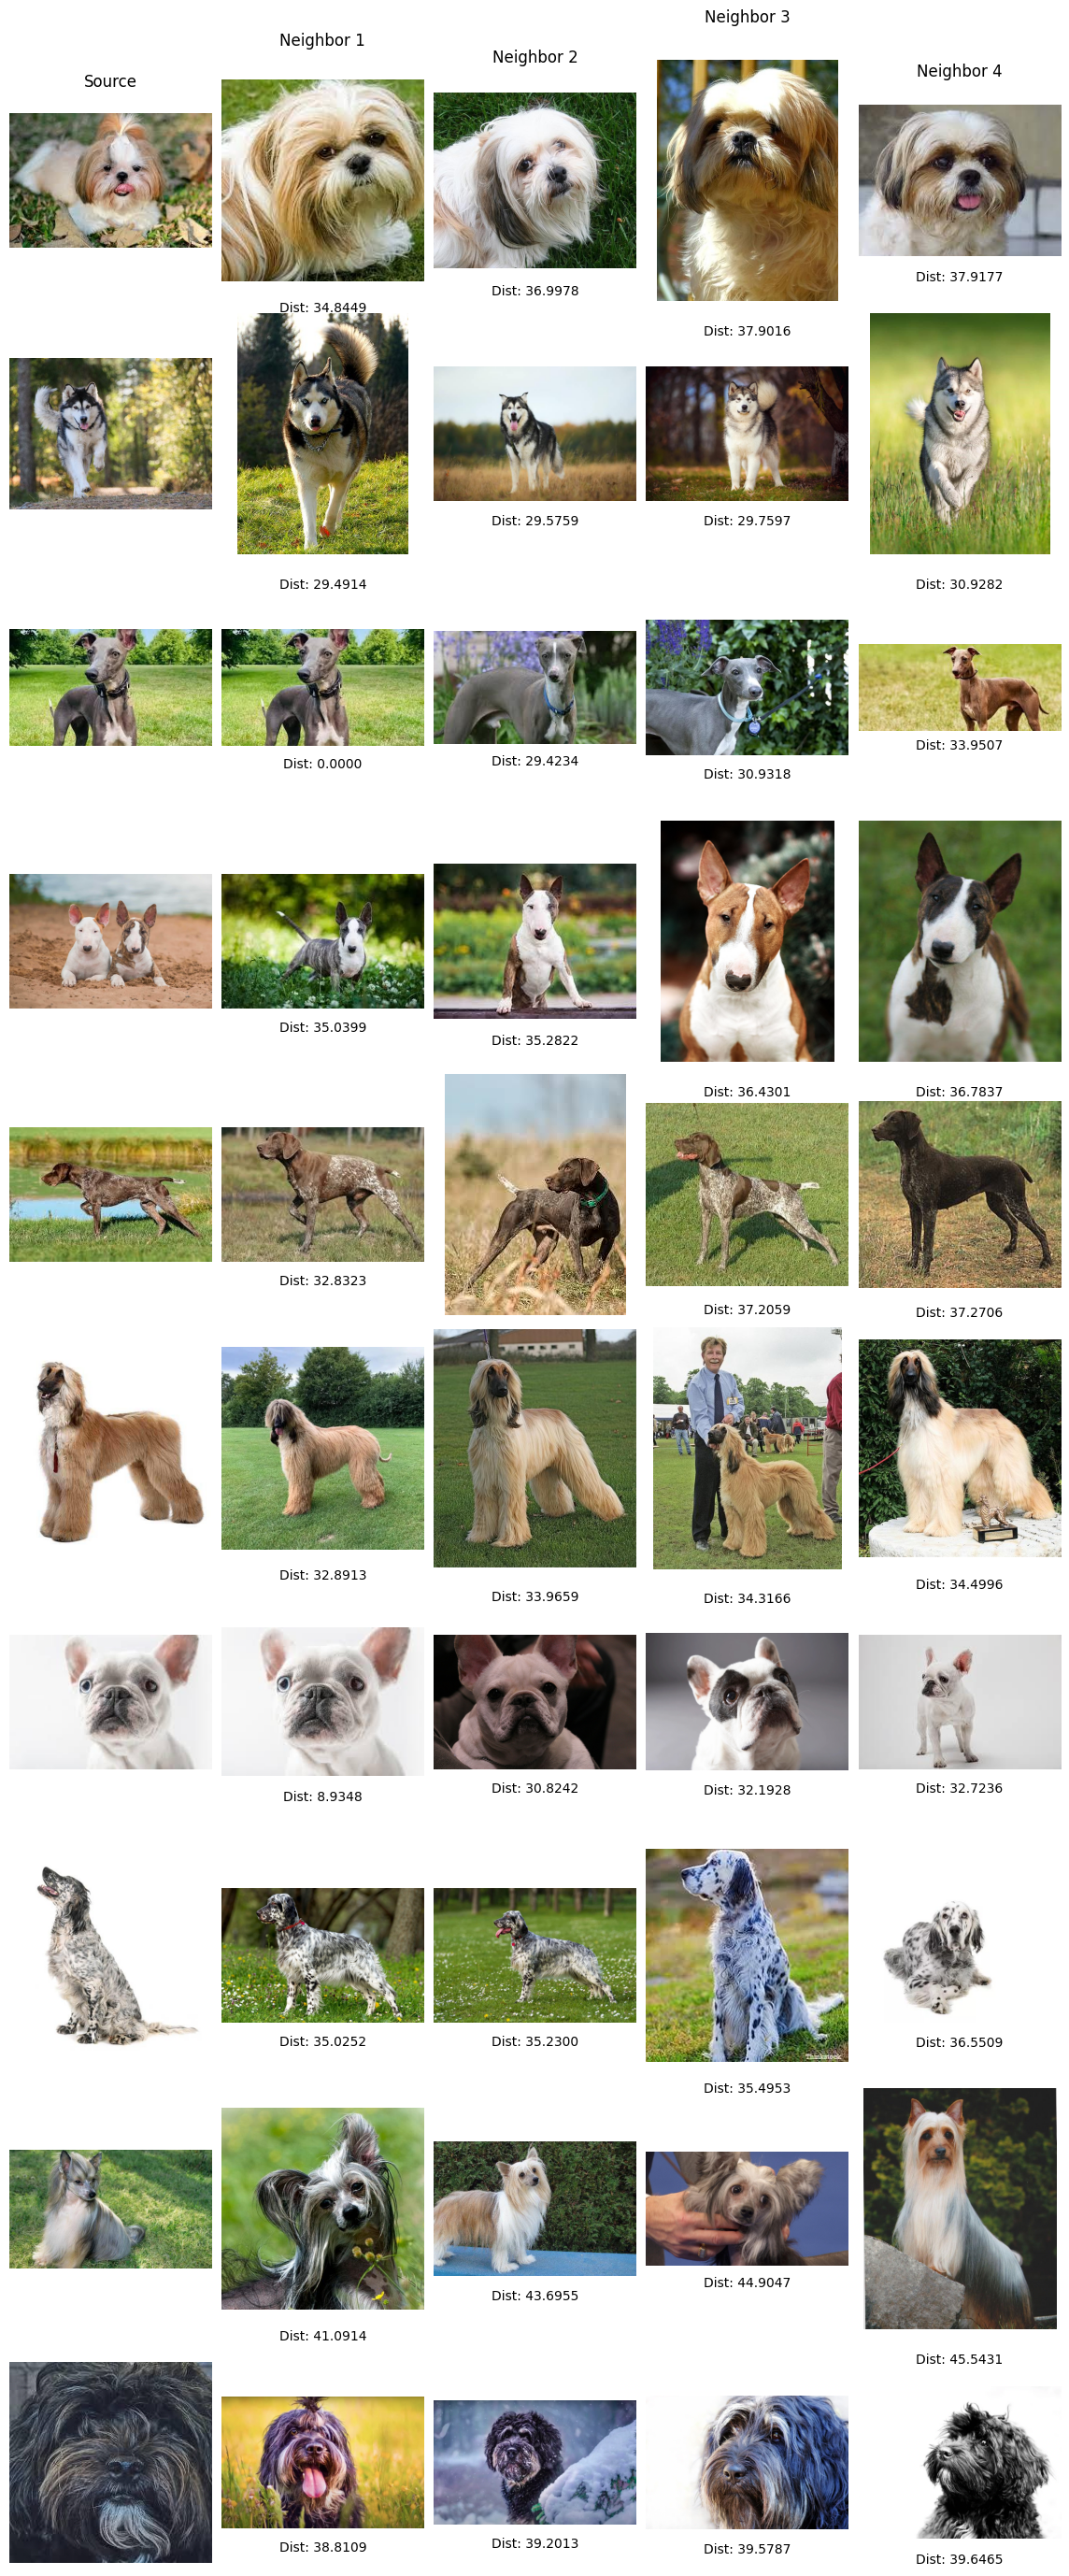

In [33]:
plot_image_neighbors(original_image_path, neightbour_img_path_list, neighbour_dist, max_neighbors=4)

По данным видно, что присутствуют дублирующиеся изображения, надо понять какой порог для них выставить

In [34]:
nearest_neighbours_dist_except_self = []

for original_index, neighbours_indeces in enumerate(pred_result[1]):
    temp_nn_dist = []
    
    for temp_ind, neighbour_ind in enumerate(neighbours_indeces):
        if neighbour_ind != original_index:
            temp_nn_dist.append(pred_result[0][original_index][temp_ind])

    nearest_neighbours_dist_except_self.append(temp_nn_dist)

In [35]:
all_dists = [temp_dist for nn_list in nearest_neighbours_dist_except_self for temp_dist in nn_list]

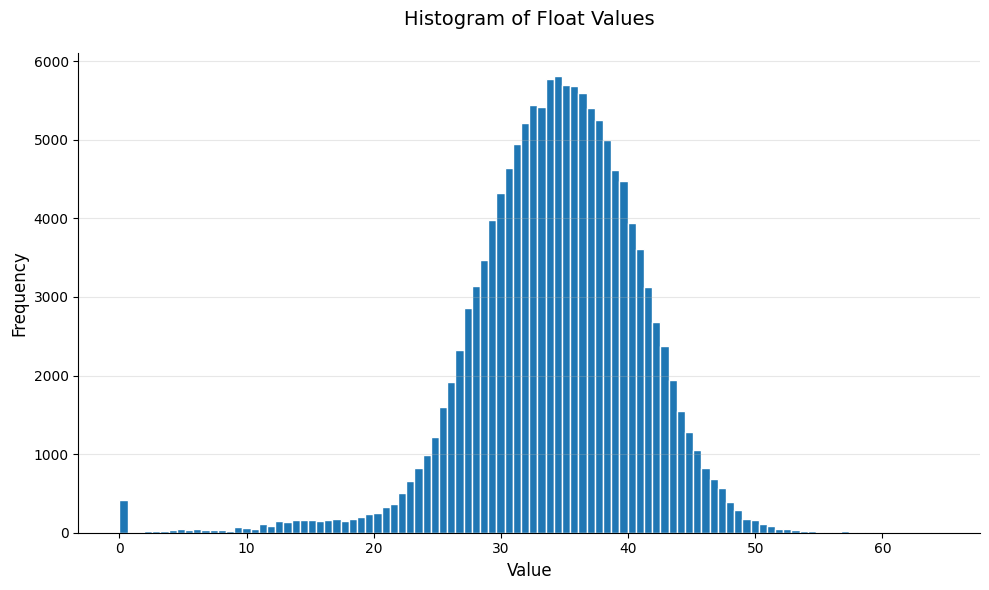

In [36]:
plt.figure(figsize=(10, 6))

plt.hist(
    all_dists,
    bins=100,
    color='#1f77b4',
    edgecolor='white',
)

plt.title('Histogram of Float Values', pad=20, fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Левый хвост скорее всего и содержит дублирующиеся изображения, соберём эти изображения в кучу (оригинал/дубликат) по порогу в 22

In [37]:
duplicate_pairs = []
used_ids = set()

neighbour_indices_matrix = pred_result[1].tolist()

for original_index, neighbours_indeces in enumerate(neighbour_indices_matrix):
    if original_index in used_ids:
        continue
    
    for temp_ind, neighbour_ind in enumerate(neighbours_indeces):
        if neighbour_ind != original_index and pred_result[0][original_index][temp_ind] <= 22:
            if neighbour_ind not in used_ids:
                duplicate_pairs.append((original_index, neighbour_ind))
                used_ids.add(neighbour_ind)

In [38]:
original_images_path_list = []
duplicate_images_path_list = []

rows_count = 10

for original_ind, duplicate_ind in duplicate_pairs[:rows_count]:
    original_images_path_list.append(imgs_path_list[original_ind])
    duplicate_images_path_list.append(imgs_path_list[duplicate_ind])

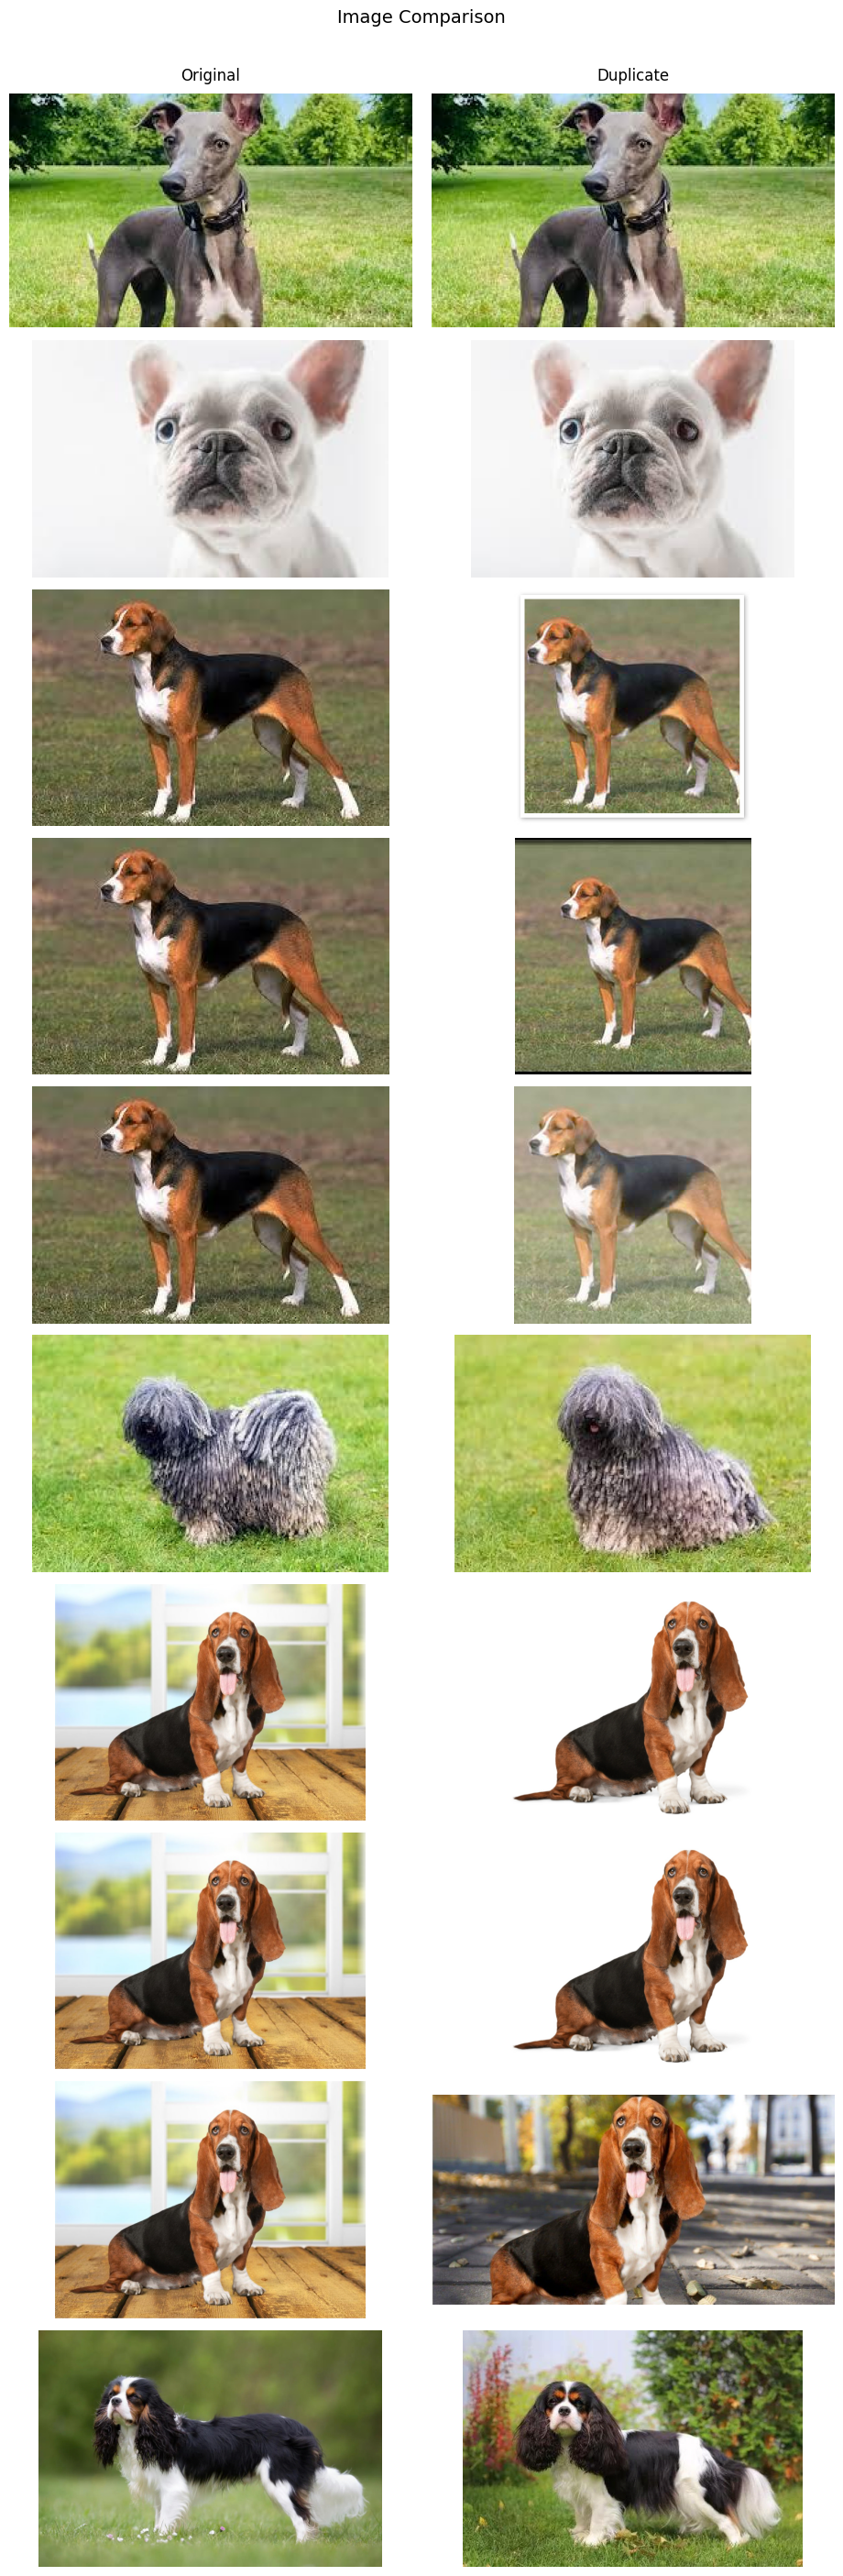

In [39]:
num_pairs = max(len(original_images_path_list), len(duplicate_images_path_list))
rows = num_pairs
cols = 2

# Calculate figure size (adjust height per row as needed)
fig_height = 3 * rows  # 3 inches per row
fig_width = 10  # Total width in inches

fig, axes = plt.subplots(
    rows, cols, 
    figsize=(fig_width, fig_height),
    squeeze=False  # Ensure axes is always 2D array
)

# Adjust spacing
plt.subplots_adjust(
    wspace=0.05,
    hspace=0.05,
    top=0.95,
    bottom=0.05,
    left=0.05,
    right=0.95
)

# Set title
fig.suptitle("Image Comparison", y=0.98, fontsize=14)

# Plot each image pair
for i in range(num_pairs):
    # Load and convert images (if paths exist)
    if i < len(original_images_path_list):
        img1 = cv2.imread(original_images_path_list[i])
        img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        axes[i, 0].imshow(img1_rgb)
        axes[i, 0].set_title("Original", pad=10) if i == 0 else None
    else:
        axes[i, 0].axis('off')  # Blank if no image
        
    if i < len(duplicate_images_path_list):
        img2 = cv2.imread(duplicate_images_path_list[i])
        img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        axes[i, 1].imshow(img2_rgb)
        axes[i, 1].set_title("Duplicate", pad=10) if i == 0 else None
    else:
        axes[i, 1].axis('off')  # Blank if no image
        
    # Turn off axes for all subplots
    for j in range(cols):
        axes[i, j].axis('off')

plt.show()

Как видно мы действительно нашли изображения, которые очень сильно друг на друга похожи, есть даже примеры, где собаку вырезали и вставляли в другой фон (5 и 9 изображения)

In [40]:
samples_ids_for_deletion = [sample_emb_list[duplicate_ind][0].id for original_ind, duplicate_ind in duplicate_pairs]
dataset.delete_samples(samples_ids_for_deletion)
dataset.save()

In [41]:
print("Размер датасета после удаления дубликатов:", len(dataset))
print("Размер исходного датасета:", base_len)
print(f"Размер датасета уменьшился на {round((base_len - len(dataset)) / base_len * 100, 2)}%")

Размер датасета после удаления дубликатов: 32306
Размер исходного датасета: 33995
Размер датасета уменьшился на 4.97%


In [42]:
dataset.export(
    export_dir="../data/deduplicated-dataset",
    dataset_type=fo.types.COCODetectionDataset,
)

Directory '../data/deduplicated-dataset' already exists; export will be merged with existing files
 100% |█████████████| 32306/32306 [20.8s elapsed, 0s remaining, 1.8K samples/s]       
